In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import integrate, interpolate, stats
import pingouin as pg

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

In [5]:
sigalpha = 0.05

In [6]:
areas_of_interest = {
    'MO': ['MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b', 'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'],
    'SM-TH': ['AV', 'CL', 'MD', 'PO', 'PF', 'VAL', 'VPL', 'VPM', 'VM'],
    'RT-TH': ['RT'],
}
areacolors = {'MO': 'blueviolet', 'SM-TH': 'limegreen', 'RT-TH': 'salmon'}

#### Functions

In [7]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [8]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

In [9]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

#### Load metadata for experiments

In [10]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [11]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\psilocybin_exp'

### Load subjects

In [12]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

In [13]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
0,psilocybin,657903,pilot_aw_psi_2023-01-13_12-18-22,"awake,psilocybin",deep,none,False,F:\psi_exp\mouse657903\pilot_aw_psi_2023-01-13...,25,"big lesion in CTX, stim closer to ORB anyway, ..."
1,psilocybin,666193,pilot_aw_psi_2023-02-16_10-55-48,psilocybin,deep,all,True,F:\psi_exp\mouse666193\pilot_aw_psi_2023-02-16...,25,no EEG
2,psilocybin,666194,pilot_aw_psi_2023-02-23_10-40-34,psilocybin,deep,none,True,F:\psi_exp\mouse666194\pilot_aw_psi_2023-02-23...,25,NaN
3,psilocybin,666196,pilot_aw_psi_2023-03-16_10-21-29,"awake,psilocybin,psilocybin,psilocybin,psilocy...",deep,all,True,F:\psi_exp\mouse666196\pilot_aw_psi_2023-03-16...,25,EEG bad?
4,psilocybin,669118,pilot_aw_psi_2023-03-24_09-55-33,"awake,psilocybin,psilocybin,psilocybin,psilocy...",deep,none,True,F:\psi_exp\mouse669118\pilot_aw_psi_2023-03-24...,25,"only has probe B, F"


## Get multi-subject metrics

In [14]:
call_saline_awake = True

skip_states = ['recovery']
psilocybin_window = 30 * 60 # min to include as "psilocybin" -> seconds; I tried 60 min on 5/10
substates = {'resting': True, 'running': False}
trial_threshold = 30 # must have more than this number of trials to be included in analysis
trial_max = 125 # limit some states that have many trials
unit_threshold = 25 # must have at least this number of units to be included in analysis, 5/10 was 5
time_bin = 0.0025 # size of time bins (s) for firing rate

sig_test_window = [0.075, 0.3]
sigalpha = 0.05 # significance threshold for unit activation
burst_window = [0.075, 0.3]
early_window = [0.002, 0.025]
late_window = [0.075, 0.3]

In [15]:
all_subjects_states_info = []
all_subjects_data = {}
for indi, subrow in subject_df.iterrows():
    if not subrow.analyze:
        print('Skipping {} - {}, experiment excluded from analysis.\n'.format(subrow.mouse, subrow.exp_type))
        continue
#     elif subrow.bad_chs == 'all':
#         print('Skipping {} - {}, all EEG chs are bad.\n'.format(subrow.mouse, subrow.exp_type))
#         continue
    print('{}: {}'.format(subrow.mouse, subrow.experiment))
    if subrow.mouse in all_subjects_data.keys():
        all_subjects_data[subrow.mouse][subrow.exp_type] = {}
    else:
        all_subjects_data[subrow.mouse] = {}
        all_subjects_data[subrow.mouse][subrow.exp_type] = {}
    
    ## Load EEGexp and stim_log ##
    exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

    ### Get all states in experiment ###
    all_sweeps = np.unique(stim_log['sweep'].values)

    ## Get state label for each sweep ##
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    if call_saline_awake:
        stim_log['state'] = ['awake' if x == 'saline' else x for x in stim_log['state'].values]
    ## Get depth label for each sweep ##
    sweep_depth_list = []
    for char in subrow.stim_depth.split(','):
        sweep_depth_list.append(char)
    if len(sweep_depth_list) == 1:
        sweep_depth_list = sweep_depth_list * len(all_sweeps)
    stim_log['stim_depth'] = stim_log.apply(lambda x: sweep_depth_list[x.sweep], axis=1)
    ## Get list of states and the middle current ##
    states = np.unique(stim_log['state'].values)
    currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
    if len(currents) > 1:
        ch_curr = str(currents[1])
    else:
        ch_curr = str(currents[0])

    ## Load unit info ##
    fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
            all_unit_event_spikes = pickle.load(unit_file)
    else:
        print(' {} not found. Not analyzing this subject.\n'.format(fn_units_info))
        continue

    ## Make time bins for event spikes ##
    bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
    timex = bins[:-1] + time_bin/2
    
    ## Separate unit info by ROI ##
    ROI_unit_info = {}
    for region in np.unique(unit_info['parent_region'].values):
        udf = unit_info[unit_info['parent_region'] == region]
        if len(udf) >= unit_threshold:
            ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
#             print('{}: {:d} units'.format(region, len(udf)))
            
    ## Get event_inds ##
    state_event_inds = {}
    for statei in states:
        if statei in skip_states:
            continue
        if statei == 'psilocybin':
            exp_meta = metadata[(
                (metadata['mouse_name'].str.contains(subrow.mouse)) &
                (metadata['exp_name'].str.contains(subrow.experiment))
            )].squeeze()
            stim_log['onset_from_inj2'] = stim_log['onset'] - float(exp_meta['Second injection time'])
            for substi, trialtest in substates.items():
                eventinds = stim_log[
                    (stim_log['stim_type'] == 'biphasic') &
                    (stim_log['parameter'] == ch_curr) &
                    (stim_log['stim_depth'] == 'deep') &
                    (stim_log['good'] == True) &
                    (stim_log['resting_trial'] == trialtest) &
                    (stim_log['state'] == statei) &
                    (stim_log['onset_from_inj2'] < psilocybin_window)
                ].index.values
                state_event_inds[statei + '_' + substi] = eventinds
        elif statei == 'awake':
            for substi, trialtest in substates.items():
                eventinds = stim_log[
                    (stim_log['stim_type'] == 'biphasic') &
                    (stim_log['parameter'] == ch_curr) &
                    (stim_log['stim_depth'] == 'deep') &
                    (stim_log['good'] == True) &
                    (stim_log['resting_trial'] == trialtest) &
                    (stim_log['state'] == statei)
                ].index.values
                state_event_inds[statei + '_' + substi] = eventinds
        else:
            eventinds = stim_log[
                (stim_log['stim_type'] == 'biphasic') &
                (stim_log['parameter'] == ch_curr) &
                (stim_log['stim_depth'] == 'deep') &
                (stim_log['good'] == True) &
                (stim_log['resting_trial'] == True) &
                (stim_log['state'] == statei)
            ].index.values
            state_event_inds[statei] = eventinds
              
    all_subjects_data[subrow.mouse][subrow.exp_type] = {
        'unit_metrics': {},
        'unit_zscores': {},
        'pop_fr': {},
        'trial_counts': {},
        'region_counts': {}
    }
    ## Get metrics for each state/region #
    for statei, event_inds in state_event_inds.items():
        if len(event_inds) < trial_threshold:
            print(' Only {:d} trials for {} state, not analyzing.'.format(len(event_inds), statei))
            continue
        elif len(event_inds) > trial_max:
            print(' {} has {:d} trials, downsampling trials to {:d}.'.format(statei, len(event_inds), trial_max))
            event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
        all_subjects_data[subrow.mouse][subrow.exp_type]['trial_counts'][statei] = len(event_inds)
        all_subjects_data[subrow.mouse][subrow.exp_type]['unit_metrics'][statei] = {}
        all_subjects_data[subrow.mouse][subrow.exp_type]['unit_zscores'][statei] = {}
        all_subjects_data[subrow.mouse][subrow.exp_type]['pop_fr'][statei] = {}
        regcount = 0
        for regi, regdf in ROI_unit_info.items():
            regcount += 1
            unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan
            sig_evoked_units = np.zeros(len(regdf), dtype=int)
            burst_trials = np.zeros(len(regdf), dtype=float)
            mean_burst_counts = np.zeros(len(regdf), dtype=float)
            early_spike_latency = np.zeros(len(regdf), dtype=float)
            late_spike_latency = np.zeros(len(regdf), dtype=float)

            ## Get unit event spike times ##
            reg_unit_metrics = []
            for ii, unitrow in regdf.iterrows():
                unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                unit_event_bursts = [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds]
                ## Get firing rates ##    
                unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))

                prespikes = np.zeros(len(event_inds), dtype=int)
                postspikes = np.zeros(len(event_inds), dtype=int)
                trial_counts = np.zeros(len(event_inds), dtype=int)
                burst_counts = np.zeros(len(event_inds), dtype=int)
                earlyfirstspikes = []
                latefirstspikes = []
                for jj, uspikesi in enumerate(unit_event_spikes):
                    ## Count spikes ##
                    prespikes[jj] = np.sum((uspikesi >= -sig_test_window[1]) & (uspikesi <= -sig_test_window[0]))
                    postspikes[jj] = np.sum((uspikesi >= sig_test_window[0]) & (uspikesi <= sig_test_window[1]))

                    ## Count bursts ##
                    windowbursts = np.nonzero(
                        (unit_event_bursts[jj] >= burst_window[0]) & (unit_event_bursts[jj] <= burst_window[1]))[0]
                    if len(windowbursts) > 0:
                        trial_counts[jj] = 1
                    burst_counts[jj] = len(np.nonzero(unit_event_bursts[jj] >= burst_window[0])[0])

                    ## Find first spikes ##
                    earlyspikes = np.nonzero((uspikesi >= early_window[0]) & (uspikesi <= early_window[1]))[0]
                    if len(earlyspikes) > 0:
                        earlyfirstspikes.append(uspikesi[earlyspikes[0]])
                    latespikes = np.nonzero((uspikesi >= late_window[0]) & (uspikesi <= late_window[1]))[0]
                    if len(latespikes) > 0:
                        latefirstspikes.append(uspikesi[latespikes[0]])

                wstat, pval = stats.wilcoxon(x=postspikes, y=prespikes, zero_method='zsplit')
                spcount = np.mean(postspikes) - np.mean(prespikes)

                reg_unit_metrics.append([
                    unitrow.unit_id, pval, spcount, np.median(earlyfirstspikes) * 1E3, np.median(latefirstspikes) * 1E3,
                    np.mean(trial_counts), np.mean(burst_counts), np.mean(unit_firing_rates[timex < 0, ii])
                ])
                sig_evoked_units[ii] = pval < sigalpha
                burst_trials[ii] = np.mean(trial_counts) # fraction of trials with burst
                mean_burst_counts[ii] = np.mean(burst_counts) # avg number of evoked bursts
                early_spike_latency[ii] = np.median(earlyfirstspikes)
                late_spike_latency[ii] = np.median(latefirstspikes)
            unit_metrics_df = regdf.merge(
                pd.DataFrame(reg_unit_metrics, columns=[
                    'unit_id', 'p_value', 'mean_spike_diff', 'early_latency', 'late_latency',
                    'burst_prob', 'burst_count', 'baselineFR'
                ]), on='unit_id', how='left')
            all_subjects_data[subrow.mouse][subrow.exp_type]['unit_metrics'][statei][regi] = unit_metrics_df
            all_subjects_data[subrow.mouse][subrow.exp_type]['unit_zscores'][statei][regi] = [
                timex, get_zFR(unit_firing_rates, timex)]
            all_subjects_data[subrow.mouse][subrow.exp_type]['pop_fr'][statei][regi] = [
                timex, np.mean(unit_firing_rates, axis=1)]
            
            all_subjects_states_info.append([
                subrow.mouse, subrow.exp_type, statei, len(event_inds), regi, len(regdf),
                np.mean(unit_firing_rates[timex < 0, :]), np.mean(sig_evoked_units), np.median(burst_trials),
                np.mean(mean_burst_counts), np.nanmedian(early_spike_latency) * 1E3, np.nanmedian(late_spike_latency) * 1E3
            ])
            all_subjects_data[subrow.mouse][subrow.exp_type]['region_counts'][statei] = regcount
    print('')
all_subs_unit_stats_df = pd.DataFrame(all_subjects_states_info, columns=[
    'mouse', 'exp_type', 'state', 'trial_count', 'region', 'num_units',
    'baselineFR', 'fraction_sig', 'burst_prob', 'burst_count', 'early_latency', 'late_latency'
])

Skipping 657903 - psilocybin, experiment excluded from analysis.

666193: pilot_aw_psi_2023-02-16_10-55-48
This data does not contain an EEG recording.
Experiment type: electrical stimulation


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



666194: pilot_aw_psi_2023-02-23_10-40-34
Experiment type: electrical stimulation
 psilocybin_resting has 187 trials, downsampling trials to 125.

666196: pilot_aw_psi_2023-03-16_10-21-29
Experiment type: electrical and sensory stimulation
 Only 10 trials for awake_resting state, not analyzing.
 psilocybin_running has 271 trials, downsampling trials to 125.

669118: pilot_aw_psi_2023-03-24_09-55-33
Experiment type: electrical stimulation
 Only 3 trials for awake_resting state, not analyzing.
 Only 17 trials for psilocybin_resting state, not analyzing.
 psilocybin_running has 305 trials, downsampling trials to 125.

669117: pilot_aw_psi_2023-03-30_11-37-07
Experiment type: electrical stimulation
 Only 16 trials for awake_running state, not analyzing.
 psilocybin_resting has 252 trials, downsampling trials to 125.

Skipping 673449 - psilocybin, experiment excluded from analysis.

673449: aw_psi_d2_2023-04-20_10-05-31
Experiment type: electrical stimulation
 F:\psi_exp\mouse673449\aw_psi_

In [16]:
all_subs_unit_stats_df['subject'] = all_subs_unit_stats_df.apply(lambda row: row['mouse'] + '_' + row['exp_type'], axis=1)

In [17]:
all_subs_unit_stats_df.head()

,mouse,exp_type,state,trial_count,region,num_units,baselineFR,fraction_sig,burst_prob,burst_count,early_latency,late_latency,subject
0,666193,psilocybin,psilocybin_resting,125,HIP,153,5.443791,0.026144,0.0,0.087111,11.658059,149.923860,666193_psilocybin
1,666193,psilocybin,psilocybin_resting,125,ILA,258,1.351163,0.019380,0.0,0.005085,12.991336,174.099942,666193_psilocybin
2,666193,psilocybin,psilocybin_resting,125,MO,158,2.571646,0.329114,0.0,0.026076,4.200171,213.201217,666193_psilocybin
3,666193,psilocybin,psilocybin_resting,125,OLF,75,3.403840,0.013333,0.0,0.032107,12.931633,150.580663,666193_psilocybin
4,666193,psilocybin,psilocybin_resting,125,PL,119,3.801714,0.176471,0.0,0.002891,6.572104,184.860485,666193_psilocybin


In [33]:
tempdf = all_subs_unit_stats_df[
    (all_subs_unit_stats_df['state'] == 'awake_resting') &
    (all_subs_unit_stats_df['region'] == 'MO')
]
tempdf

,mouse,exp_type,state,trial_count,region,num_units,baselineFR,fraction_sig,burst_prob,burst_count,early_latency,late_latency,subject
90,669117,psilocybin,awake_resting,98,MO,48,1.658163,0.062500,0.000000,0.004677,3.767168,189.440121,669117_psilocybin
186,654181,isoflurane,awake_resting,34,MO,134,4.462357,0.089552,0.000000,0.048727,5.047297,186.374759,654181_isoflurane
208,551397,isoflurane,awake_resting,96,MO,89,4.267732,0.505618,0.000000,0.131905,4.123867,168.331722,551397_isoflurane
220,551399,isoflurane,awake_resting,108,MO,99,2.974420,0.525253,0.000000,0.028994,5.541796,190.493990,551399_isoflurane
232,569062,isoflurane,awake_resting,102,MO,132,3.814542,0.462121,0.000000,0.073827,4.070706,186.070920,569062_isoflurane
244,569064,isoflurane,awake_resting,116,MO,29,2.094828,0.379310,0.000000,0.012188,3.497161,210.378462,569064_isoflurane
254,569068,isoflurane,awake_resting,99,MO,62,5.274682,0.370968,0.010101,0.153959,3.713208,166.769586,569068_isoflurane
266,569069,isoflurane,awake_resting,82,MO,32,4.699123,0.687500,0.000000,0.315930,3.364580,207.955026,569069_isoflurane
287,569073,isoflurane,awake_resting,86,MO,29,2.854651,0.517241,0.000000,0.163192,5.732630,173.300912,569073_isoflurane
301,571619,isoflurane,awake_resting,97,MO,103,2.487188,0.339806,0.000000,0.025323,6.303434,187.048963,571619_isoflurane


## Make multi-sub figure

In [18]:
all_states = {
    'awake_resting': 'o', 'awake_running': 'X',
    'psilocybin_resting': 's', 'psilocybin_running': 'P',
    'isoflurane': '^', 'urethane': 'v',
}
stlabels = ['AW\nrest', 'AW\nrun', 'PSI\nrest', 'PSI\nrun', 'ISO', 'UR']

In [18]:
metric_dict = {
    'baselineFR': ['Baseline firing rate', '(Hz)'],
    'fraction_sig': ['Significant response', 'Fraction of pop.'],
    'early_latency': ['First spike latency', 'Time from stim (ms)'],
    'late_latency': ['Rebound spike latency', 'Time from stim (ms)'],
    'burst_prob': ['Burst probability', 'Fraction of trials'],
    'burst_count': ['Burst count', 'Mean evoked\nburst count'],
}

<IPython.core.display.Javascript object>


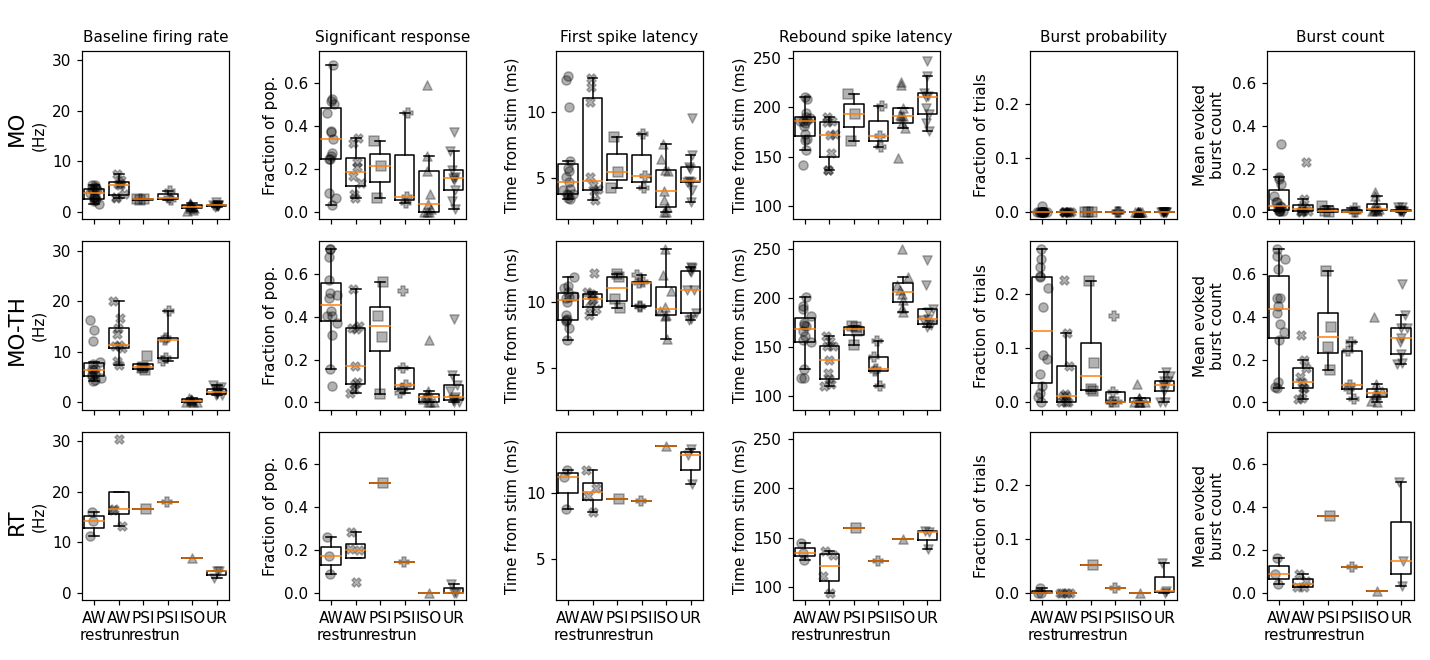

In [19]:
plot_regions = ['MO', 'SM-TH', 'RT-TH']

## Figure 1, all areas separate ##
fig, axs = plt.subplots(nrows=len(plot_regions), ncols=len(metric_dict), figsize=(13, 6), sharex=True, sharey='col')
fig.set_tight_layout({'rect': [0.01, 0, 1, 0.98]})

for ii, regi in enumerate(plot_regions):
    for kk, (statei, stmarker) in enumerate(all_states.items()):
        tempdf = all_subs_unit_stats_df[
            (all_subs_unit_stats_df['region'] == regi) & (all_subs_unit_stats_df['state'] == statei)
        ]
        xs = np.random.normal(kk, 0.1, len(tempdf))
        for jj, (met, metinfo) in enumerate(metric_dict.items()):
            axs[ii,jj].boxplot(tempdf[met].values, positions=[kk], widths=[0.8], showfliers=False)
            axs[ii,jj].scatter(xs, tempdf[met].values, c='k', marker=stmarker, alpha=0.3)
            if kk == 0:
                axs[ii,jj].set_ylabel(metinfo[1])
                if ii == 0:
                    axs[ii,jj].set_title(metinfo[0])

axs[0,0].set_xticks(list(range(len(stlabels))))
axs[0,0].set_xticklabels(stlabels)
fig.text(0.005, 0.805, 'MO', va='center', rotation='vertical', fontsize=14)
fig.text(0.005, 0.5, 'MO-TH', va='center', rotation='vertical', fontsize=14)
fig.text(0.005, 0.21, 'RT', va='center', rotation='vertical', fontsize=14)

## Save ##
figname = 'allSUBS_unitmetrics_allstates_regsep.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Plot spike latency

Apply a two-way ANOVA

If there is a significant interaction -> run all the comparisons (the order of the "between" factors matters!).

If there is not a significant interaction, but there is a significant main effect, you can run post hoc tests on the factor with an effect.

##### Try plotting in a new way

<IPython.core.display.Javascript object>


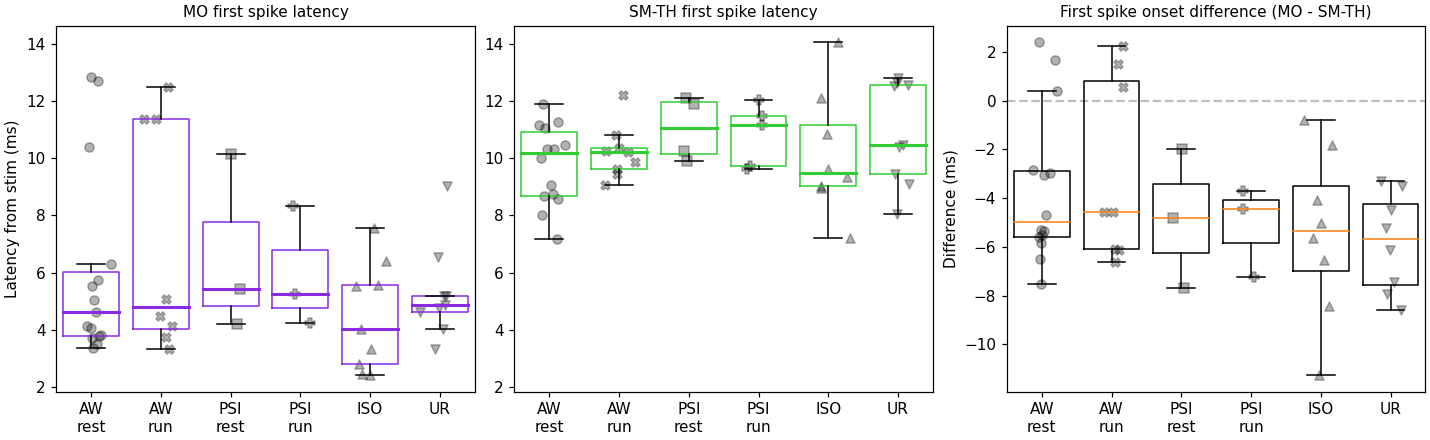

MO: ANOVA between states p-val = 5.662E-01

SM-TH: ANOVA between states p-val = 4.639E-01

latency_diff: ANOVA between states p-val = 3.681E-01


In [139]:
plot_areas = {'MO': 'blueviolet', 'SM-TH': 'limegreen'}
plot_metric = 'early_latency'
plot_title = 'first spike latency'
ystart = 220
delta = 6

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(13, 4), constrained_layout=True, sharex=True)
stargs = {'xycoords': 'data', 'fontsize': 12, 'fontweight': 'bold', 'ha': 'left', 'va': 'center'}
axs[0].get_shared_y_axes().join(axs[0], axs[1])

for jj, (regi, rcolor) in enumerate(plot_areas.items()):
    regdf = all_subs_unit_stats_df[all_subs_unit_stats_df['region'] == regi]
    for ii, (statei, stmarker) in enumerate(all_states.items()):
        tempdf = regdf[regdf['state'] == statei]
        xs = np.random.normal(ii, 0.1, len(tempdf)) # np.zeros(len(tempdf)) + ii
        axs[jj].scatter(xs, tempdf[plot_metric].values, c='k', marker=stmarker, alpha=0.3)
        axs[jj].boxplot(
            tempdf[plot_metric].values, positions=[ii], widths=[0.8], showfliers=False,
            medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
        )
    axs[jj].set_title(regi + ' ' + plot_title)
    
    ## Stats ##
    metricANOVA = pg.anova(data=regdf, dv=plot_metric, between='state', detailed=True)
    print('{}: ANOVA between states p-val = {:.3E}'.format(regi, metricANOVA['p-unc'].values[0]))
    if metricANOVA['p-unc'].values[0] < sigalpha:
        metricposthoc = pg.pairwise_tests(data=regdf, dv=plot_metric, between='state', padjust='fdr_bh')
        sigdf = metricposthoc[metricposthoc['p-corr'] < sigalpha].reset_index(drop=True)
        print(' Significant effect of state on {}. Posthoc tests find {:d} sig diffs.'.format(plot_metric, len(sigdf)))
#         for indi, sigrow in sigdf.iterrows():
#             xA = np.nonzero(np.array(list(all_states.keys())) == sigrow.A)[0][0]
#             xB = np.nonzero(np.array(list(all_states.keys())) == sigrow.B)[0][0]
#             axs[jj].plot([xA, xB], [ystart + indi * delta, ystart + indi * delta], color='k', linewidth=2)
#             axs[jj].annotate(p_stars(sigrow['p-corr']), xy=(np.min([xA, xB]), ystart + indi * delta), **stargs)
    print('')


## Difference between areas ##
axs[2].axhline(0, color='k', linestyle='dashed', alpha=0.25)
all_states_subvals = []
for ii, (statei, stmarker) in enumerate(all_states.items()):
    stdf = all_subs_unit_stats_df[all_subs_unit_stats_df['state'] == statei]
    subvals = np.zeros(len(np.unique(stdf['subject'].values)), dtype=float) * np.nan
    for jj, subi in enumerate(np.unique(stdf['subject'].values)):
        subdf = stdf[stdf['subject'] == subi]
        tempvals = np.zeros(len(plot_areas), dtype=float) * np.nan
        for kk, regi in enumerate(plot_areas.keys()):
            if regi in subdf['region'].values:
                tempvals[kk] = subdf[subdf['region'] == regi].squeeze()[plot_metric]
        subvals[jj] = tempvals[0] - tempvals[1]
        all_states_subvals.append([statei, subi, subvals[jj]])
    xs = np.random.normal(ii, 0.1, len(subvals))
    axs[2].scatter(xs, subvals, c='k', marker=stmarker, alpha=0.3)
    axs[2].boxplot(subvals[~np.isnan(subvals)], positions=[ii], widths=[0.8], showfliers=False)
lat_diff_df = pd.DataFrame(all_states_subvals, columns=['state', 'subject', 'latency_diff'])
metricANOVA = pg.anova(data=lat_diff_df, dv='latency_diff', between='state', detailed=True)
print('{}: ANOVA between states p-val = {:.3E}'.format('latency_diff', metricANOVA['p-unc'].values[0]))
if metricANOVA['p-unc'].values[0] < sigalpha:
    metricposthoc = pg.pairwise_tests(data=lat_diff_df, dv='latency_diff', between='state', padjust='fdr_bh')
    sigdf = metricposthoc[metricposthoc['p-corr'] < sigalpha].reset_index(drop=True)
    print(' Significant effect of state on {}. Posthoc tests find {:d} sig diffs.'.format(plot_metric, len(sigdf)))
#     yst = 60
#     deltay = 5
#     for indi, sigrow in sigdf.iterrows():
#         xA = np.nonzero(np.array(list(all_states.keys())) == sigrow.A)[0][0]
#         xB = np.nonzero(np.array(list(all_states.keys())) == sigrow.B)[0][0]
#         axs[2].plot([xA, xB], [yst + indi * deltay, yst + indi * deltay], color='k', linewidth=2)
#         axs[2].annotate(p_stars(sigrow['p-corr']), xy=(np.min([xA, xB]), yst + indi * deltay), **stargs)
    
    
axs[0].set_ylabel('Latency from stim (ms)')
axs[0].set_xticks(range(len(all_states)))
axs[0].set_xticklabels(stlabels)
axs[2].set_title('First spike onset difference (MO - SM-TH)')
axs[2].set_ylabel('Difference (ms)')
        
## Save ##
figname = 'allSUBS_{}_separated.png'.format(plot_metric)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

In [19]:
plot_areas = {'MO': 'blueviolet', 'SM-TH': 'limegreen'}
plot_metric = 'late_latency'
plot_title = 'Rebound spike latency across subjects'

regdfs = []
for regi in plot_areas.keys():
    regdfs.append(all_subs_unit_stats_df[(all_subs_unit_stats_df['region'] == regi)])
regionsdf = pd.concat(regdfs)
regionsdf.head()

,mouse,exp_type,state,trial_count,region,num_units,baselineFR,fraction_sig,burst_prob,burst_count,early_latency,late_latency,subject
2,666193,psilocybin,psilocybin_resting,125,MO,158,2.571646,0.329114,0.0,0.026076,4.200171,213.201217,666193_psilocybin
12,666193,psilocybin,psilocybin_running,115,MO,158,4.144496,0.069620,0.0,0.019483,4.247804,160.149756,666193_psilocybin
41,666196,psilocybin,awake_running,110,MO,28,2.856656,0.321429,0.0,0.000974,5.068673,190.395384,666196_psilocybin
53,666196,psilocybin,psilocybin_resting,58,MO,28,2.649938,0.214286,0.0,0.001232,5.420034,193.168367,666196_psilocybin
65,666196,psilocybin,psilocybin_running,125,MO,28,2.336571,0.500000,0.0,0.001143,5.258178,209.084009,666196_psilocybin


In [25]:
for regi in plot_areas.keys():
    print(regi)
    for statei in all_states.keys():
        statevals = regionsdf[(regionsdf['region'] == regi) & (regionsdf['state'] == statei)][plot_metric].values
        if len(statevals) > 2:
            swstat, swp = stats.shapiro(statevals)
            if swp < sigalpha:
                normtag = 'NOT normal'
            else:
                normtag = 'normal'
        else:
            normtag = 'cannot run Shapiro-Wilk'
        print(' {}: N={:d}; {}; mean={:.2f}, SEM={:.2f}'.format(
            statei, len(statevals), normtag, np.mean(statevals), np.std(statevals)/np.sqrt(len(statevals))
        ))
    print('')

MO
 awake_resting: N=15; normal; mean=182.27, SEM=4.31
 awake_running: N=8; normal; mean=166.27, SEM=6.43
 psilocybin_resting: N=3; normal; mean=193.86, SEM=8.96
 psilocybin_running: N=3; normal; mean=180.10, SEM=12.11
 isoflurane: N=9; normal; mean=192.58, SEM=7.27
 urethane: N=9; normal; mean=207.18, SEM=6.89

SM-TH
 awake_resting: N=14; normal; mean=162.68, SEM=6.71
 awake_running: N=9; normal; mean=135.19, SEM=6.51
 psilocybin_resting: N=4; normal; mean=164.73, SEM=3.76
 psilocybin_running: N=5; normal; mean=131.18, SEM=6.54
 isoflurane: N=8; normal; mean=208.48, SEM=6.69
 urethane: N=9; NOT normal; mean=193.10, SEM=7.36



Normality test and stats for latency diff

In [123]:
lat_diff_df = pd.DataFrame(all_states_subvals, columns=['state', 'subject', 'latency_diff'])
state_pvals = []
for ii, statei in enumerate(all_states.keys()):
    statevals = lat_diff_df[lat_diff_df['state'] == statei]['latency_diff'].values
    statevals = statevals[~np.isnan(statevals)]
    if len(statevals) > 2:
        swstat, swp = stats.shapiro(statevals)
        if swp < sigalpha:
            normtag = 'NOT normal'
        else:
            normtag = 'normal'
    else:
        normtag = 'cannot run Shapiro-Wilk'
    print('{}: N={:d}; {}; mean={:.2f}, SEM={:.2f}'.format(
        statei, len(statevals), normtag, np.mean(statevals), np.std(statevals)/np.sqrt(len(statevals))
    ))
    pgstats = pg.ttest(statevals, 0.)
    state_pvals.append(pgstats['p-val'].values[0])
    print(' T-test p-value = {:.4f}\n'.format(pgstats['p-val'].values[0]))

awake_resting: N=14; normal; mean=17.58, SEM=5.74
 T-test p-value = 0.0113

awake_running: N=8; normal; mean=28.21, SEM=3.21
 T-test p-value = 0.0001

psilocybin_resting: N=3; normal; mean=29.11, SEM=5.68
 T-test p-value = 0.0527

psilocybin_running: N=3; normal; mean=40.71, SEM=6.15
 T-test p-value = 0.0325

isoflurane: N=8; normal; mean=-15.72, SEM=6.40
 T-test p-value = 0.0552

urethane: N=8; normal; mean=12.65, SEM=6.98
 T-test p-value = 0.1337



In [124]:
state_pcorr = pg.multicomp(state_pvals, method='fdr_bh')
state_pcorr

(array([ True,  True, False, False, False, False]),
 array([0.03384365, 0.00046162, 0.06623138, 0.06509004, 0.06623138,
        0.13369028]))

### Plot baseline firing rates

In [75]:
np.unique(all_subs_unit_stats_df['region'].values)

array(['ACA', 'AI', 'FRP', 'HIP', 'ILA', 'MO', 'OLF', 'ORB', 'PAL', 'PL',
       'PTLp', 'RHP', 'RSP', 'RT-TH', 'SM-TH', 'SS', 'STR', 'VIS',
       'other-TH'], dtype=object)

In [100]:
plot_region = 'ILA'
plot_metric = 'baselineFR'

regiondf = all_subs_unit_stats_df[all_subs_unit_stats_df['region'] == plot_region]

In [101]:
for statei in all_states.keys():
    statevals = regiondf[regiondf['state'] == statei][plot_metric].values
    print(statei)
    if len(statevals) > 2:
        swstat, swp = stats.shapiro(statevals)
        if swp < sigalpha:
            normtag = 'NOT normal'
        else:
            normtag = 'normal'
    else:
        normtag = 'cannot run Shapiro-Wilk'
    print(' N={:d}; {}; mean={:.1f}, SEM={:.1f}\n'.format(
        len(statevals), normtag, np.mean(statevals), np.std(statevals)/np.sqrt(len(statevals))
    ))

awake_resting
 N=3; normal; mean=1.5, SEM=0.2

awake_running
 N=3; normal; mean=2.4, SEM=0.3

psilocybin_resting
 N=3; normal; mean=1.8, SEM=0.4

psilocybin_running
 N=3; normal; mean=2.1, SEM=0.5

isoflurane
 N=0; cannot run Shapiro-Wilk; mean=nan, SEM=nan

urethane
 N=3; normal; mean=1.1, SEM=0.2



C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Apply a one-way ANOVA

In [86]:
metricANOVA = pg.anova(data=regiondf, dv=plot_metric, between='state', detailed=True)
print('ANOVA between states p-val = {:.3E}'.format(metricANOVA['p-unc'].values[0]))
if metricANOVA['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state on {}, now perform posthoc tests.'.format(plot_metric))
    metricposthoc = pg.pairwise_tests(data=regiondf, dv=plot_metric, between='state', padjust='fdr_bh')

ANOVA between states p-val = 3.902E-10
There is a significant effect of state on baselineFR, now perform posthoc tests.


In [87]:
sigdf = metricposthoc[metricposthoc['p-corr'] < sigalpha]
sigdf

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
1,state,awake_resting,isoflurane,False,True,7.862957,19.992495,two-sided,1.524679e-07,0.000002,fdr_bh,5.797e+04,2.892988
4,state,awake_resting,urethane,False,True,6.637128,17.864935,two-sided,3.262201e-06,0.000016,fdr_bh,4794.956,2.520830
5,state,awake_running,isoflurane,False,True,8.542031,14.559693,two-sided,4.747099e-07,0.000004,fdr_bh,2.418e+04,3.867492
8,state,awake_running,urethane,False,True,7.230509,13.960620,two-sided,4.424435e-06,0.000017,fdr_bh,2736.3,3.348397
9,state,isoflurane,psilocybin_resting,False,True,-5.548254,5.729914,two-sided,1.685690e-03,0.003612,fdr_bh,81.399,-3.213892
10,state,isoflurane,psilocybin_running,False,True,-6.245628,5.953591,two-sided,8.042377e-04,0.002413,fdr_bh,258.527,-3.710745
13,state,psilocybin_resting,urethane,False,True,4.560243,6.488982,two-sided,3.158467e-03,0.005922,fdr_bh,21.352,2.596703
14,state,psilocybin_running,urethane,False,True,5.464870,6.572900,two-sided,1.160705e-03,0.002902,fdr_bh,76.862,3.164101


Plot it

<IPython.core.display.Javascript object>


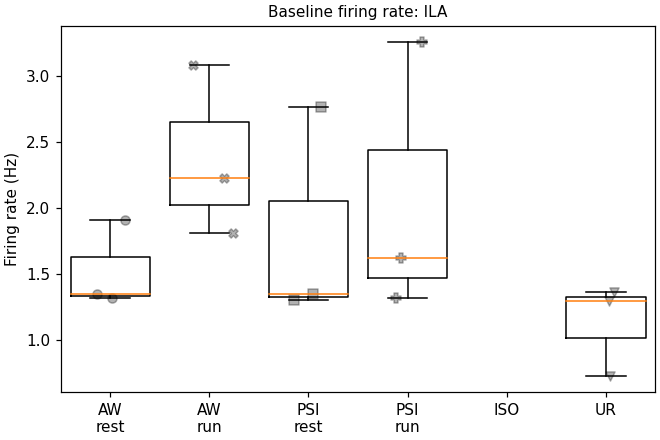

In [102]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

for ii, (statei, stmarker) in enumerate(all_states.items()):
    tempdf = regiondf[regiondf['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(tempdf)) # np.zeros(len(tempdf)) + locs[ii,jj]
    ax.scatter(xs, tempdf[plot_metric].values, c='k', marker=stmarker, alpha=0.3)
    ax.boxplot(
        tempdf[plot_metric].values, positions=[ii], widths=[0.8], showfliers=False,
#         medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
    )
ax.set_title('Baseline firing rate: {}'.format(plot_region))
ax.set_ylabel('Firing rate (Hz)')
ax.set_xticklabels(stlabels)

## Add stats ##
# for (indi, sigrow), yval in zip(sigdf.iterrows(), [7, 7.5, 8, 8.5, 9, 10, 9.5, 10.5]):
#     xA = np.nonzero(np.array(list(all_states.keys())) == sigrow.A)[0][0]
#     xB = np.nonzero(np.array(list(all_states.keys())) == sigrow.B)[0][0]
#     ax.plot([xA, xB], [yval, yval], color='k', linewidth=2)
#     ax.annotate(
#         p_stars(sigrow['p-corr']), xy=(np.min([xA, xB]), yval), xycoords='data', # np.min([xA, xB]); (xA + xB)/2
#         fontsize=12, fontweight='bold', ha='left', va='center'
#     )
    
## Save ##
figname = '{}_{}_all_subs_states.png'.format(plot_region, plot_metric)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Plot rebound burst probability

In [86]:
plot_region = 'SM-TH'
plot_metric = 'burst_count'

regiondf = all_subs_unit_stats_df[all_subs_unit_stats_df['region'] == plot_region]

In [87]:
for statei in all_states.keys():
    statevals = regiondf[regiondf['state'] == statei][plot_metric].values
    print(statei)
    if len(statevals) > 2:
        swstat, swp = stats.shapiro(statevals)
        if swp < sigalpha:
            normtag = 'NOT normal'
        else:
            normtag = 'normal'
    else:
        normtag = 'cannot run Shapiro-Wilk'
    print(' N={:d}; {}; mean={:.3f}, SEM={:.3f}\n'.format(
        len(statevals), normtag, np.mean(statevals), np.std(statevals)/np.sqrt(len(statevals))
    ))

awake_resting
 N=14; normal; mean=0.413, SEM=0.058

awake_running
 N=9; normal; mean=0.120, SEM=0.031

psilocybin_resting
 N=4; normal; mean=0.337, SEM=0.086

psilocybin_running
 N=5; normal; mean=0.138, SEM=0.048

isoflurane
 N=8; NOT normal; mean=0.085, SEM=0.043

urethane
 N=9; normal; mean=0.305, SEM=0.037



Apply a Kruskal-Wallis H-test (non-parametric one-way ANOVA due to non-normal distributions)

In [88]:
dist_normal = True

In [89]:
if dist_normal:
    metricANOVA = pg.anova(data=regiondf, dv=plot_metric, between='state', detailed=True)
    print('ANOVA between states p-val = {:.3E}'.format(metricANOVA['p-unc'].values[0]))
    if metricANOVA['p-unc'].values[0] < sigalpha:
        print('There is a significant effect of state on {}, now perform posthoc tests.'.format(plot_metric))
        metricposthoc = pg.pairwise_tests(data=regiondf, dv=plot_metric, between='state', parametric=True, padjust='fdr_bh')
else:
    metricANOVA = pg.kruskal(data=regiondf, dv=plot_metric, between='state', detailed=True)
    print('ANOVA between states p-val = {:.3E}'.format(metricANOVA['p-unc'].values[0]))
    if metricANOVA['p-unc'].values[0] < sigalpha:
        print('There is a significant effect of state on {}, now perform posthoc tests.'.format(plot_metric))
        metricposthoc = pg.pairwise_tests(data=regiondf, dv=plot_metric, between='state', parametric=False, padjust='fdr_bh')

ANOVA between states p-val = 1.334E-04
There is a significant effect of state on burst_count, now perform posthoc tests.


In [90]:
metricposthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,awake_resting,awake_running,False,True,4.285634,19.181550,two-sided,0.000392,0.002938,fdr_bh,73.983,1.512935
1,state,awake_resting,isoflurane,False,True,4.344828,19.963803,two-sided,0.000315,0.002938,fdr_bh,75.562,1.606791
2,state,awake_resting,psilocybin_resting,False,True,0.657842,5.432614,two-sided,0.537495,0.628238,fdr_bh,0.53,0.330253
3,state,awake_resting,psilocybin_running,False,True,3.407795,13.547084,two-sided,0.004429,0.013286,fdr_bh,11.075,1.284435
4,state,awake_resting,urethane,False,True,1.506898,20.395513,two-sided,0.147170,0.220755,fdr_bh,0.851,0.544738
5,state,awake_running,isoflurane,False,True,0.622330,13.017436,two-sided,0.544473,0.628238,fdr_bh,0.479,0.291913
6,state,awake_running,psilocybin_resting,False,True,-2.078311,3.681629,two-sided,0.112233,0.210436,fdr_bh,1.581,-1.512958
7,state,awake_running,psilocybin_running,False,True,-0.279741,7.017679,two-sided,0.787742,0.787742,fdr_bh,0.469,-0.155555
8,state,awake_running,urethane,False,True,-3.631701,16.000000,two-sided,0.002244,0.009456,fdr_bh,15.824,-1.630476
9,state,isoflurane,psilocybin_resting,False,True,-2.308582,4.345539,two-sided,0.076923,0.164836,fdr_bh,1.969,-1.514451


In [91]:
sigdf = metricposthoc[metricposthoc['p-corr'] < sigalpha]
sigdf

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,awake_resting,awake_running,False,True,4.285634,19.181550,two-sided,0.000392,0.002938,fdr_bh,73.983,1.512935
1,state,awake_resting,isoflurane,False,True,4.344828,19.963803,two-sided,0.000315,0.002938,fdr_bh,75.562,1.606791
3,state,awake_resting,psilocybin_running,False,True,3.407795,13.547084,two-sided,0.004429,0.013286,fdr_bh,11.075,1.284435
8,state,awake_running,urethane,False,True,-3.631701,16.000000,two-sided,0.002244,0.009456,fdr_bh,15.824,-1.630476
11,state,isoflurane,urethane,False,True,-3.657089,14.244856,two-sided,0.002522,0.009456,fdr_bh,15.274,-1.697849


Plot it

<IPython.core.display.Javascript object>


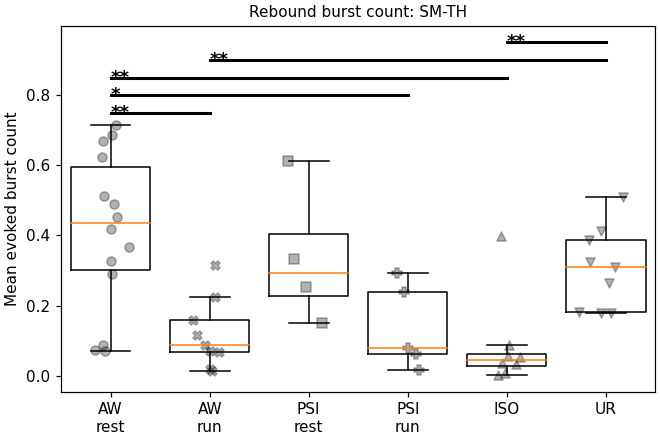

In [94]:
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

for ii, (statei, stmarker) in enumerate(all_states.items()):
    tempdf = regiondf[regiondf['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(tempdf)) # np.zeros(len(tempdf)) + locs[ii,jj]
    ax.scatter(xs, tempdf[plot_metric].values, c='k', marker=stmarker, alpha=0.3)
    ax.boxplot(
        tempdf[plot_metric].values, positions=[ii], widths=[0.8], showfliers=False,
#         medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
    )
ax.set_title('Rebound burst count: {}'.format(plot_region))
ax.set_ylabel('Mean evoked burst count')
ax.set_xticklabels(stlabels)

## Add stats ##
for (indi, sigrow), yval in zip(sigdf.iterrows(), [0.75, 0.85, 0.8, 0.9, 0.95]):
    xA = np.nonzero(np.array(list(all_states.keys())) == sigrow.A)[0][0]
    xB = np.nonzero(np.array(list(all_states.keys())) == sigrow.B)[0][0]
    ax.plot([xA, xB], [yval, yval], color='k', linewidth=2)
    ax.annotate(
        p_stars(sigrow['p-corr']), xy=(np.min([xA, xB]), yval), xycoords='data', # np.min([xA, xB]); (xA + xB)/2
        fontsize=12, fontweight='bold', ha='left', va='center'
    )
    
## Save ##
figname = '{}_{}_all_subs_states.png'.format(plot_region, plot_metric)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Single subject baseline firing rate comparisons

In [289]:
mouse = '666196'
exp_type = 'psilocybin'
print(all_subjects_data[mouse][exp_type]['unit_metrics'].keys())

dict_keys(['awake_running', 'psilocybin_resting', 'psilocybin_running'])


<IPython.core.display.Javascript object>


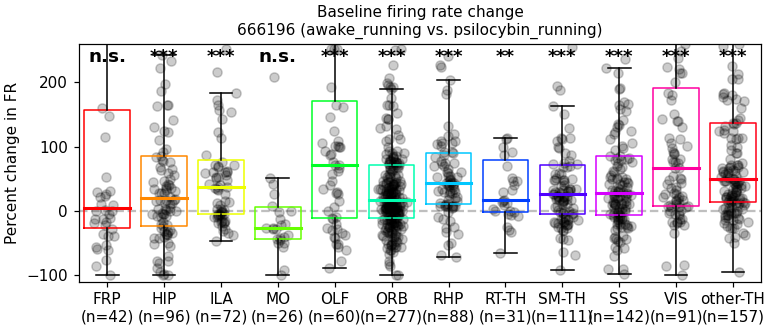

In [290]:
compare_states = ['awake_running', 'psilocybin_running']
FRrange = (0, 25)
pbins = FRrange[1] * 2
ylim = 260

all_regions = list(all_subjects_data[mouse][exp_type]['unit_metrics'][compare_states[0]].keys())
acolors = plt.cm.hsv(np.linspace(0, 1, len(all_regions)))

fig, ax = plt.subplots(figsize=(7,3), constrained_layout=True)
xlabels = []
pvals = []
ax.axhline(0, color='k', linestyle='dashed', alpha=0.25)
for ii, regi in enumerate(all_regions):
    scatter_vals = []
    for statei in compare_states:
        tempdf = all_subjects_data[mouse][exp_type]['unit_metrics'][statei][regi]
        scatter_vals.append(tempdf['baselineFR'].values)
    scatter_vals = np.stack(scatter_vals)
    scatter_vals = scatter_vals[:, np.nonzero(scatter_vals[0,:])[0]]

#     plot_yvals = scatter_vals[1,:] / scatter_vals[0,:] # simple ratio
    plot_yvals = ((scatter_vals[1,:] - scatter_vals[0,:]) / scatter_vals[0,:]) * 100 # percent increase: ((B-A) / A) * 100

    xs = np.random.normal(ii, 0.1, len(plot_yvals))
    ax.scatter(xs, plot_yvals, c='k', marker='o', alpha=0.2)
    ax.boxplot(
        plot_yvals, positions=[ii], widths=[0.8], showfliers=False,
        medianprops={'color': acolors[ii], 'linewidth': 2}, boxprops={'color': acolors[ii]}
    )
    xlabels.append('{}\n(n={:d})'.format(regi, scatter_vals.shape[1]))
    
    wilc = pg.wilcoxon(plot_yvals)
    pvals.append(wilc['p-val'].values[0])
corr_pvals = pg.multicomp(pvals, method='fdr_bh')
for ii, regi in enumerate(all_regions):
    ax.annotate(
        p_stars(corr_pvals[1][ii]), xy=(ii, ylim-20), xycoords='data',
        fontsize=12, fontweight='bold', ha='center', va='center'
    )

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels)
ax.set_ylim([-110, ylim])
ax.set_ylabel('Percent change in FR')
ax.set_title('Baseline firing rate change\n{} ({} vs. {})'.format(
    mouse, compare_states[0], compare_states[1]))

## Save ##
figname = '{}_{}_{}_all_units_BLFR.png'.format(mouse, compare_states[0], compare_states[1])
fig.savefig(os.path.join(plotsdir, 'ind_sub_evoked_units', figname), transparent=False, dpi=300)

Plot all areas

#### Test plotting each subject

666193: 5 states/3 regions; 669118: 3/2; 655955: 1/3; 657903: 4/1

In [15]:
all_states = {
    'awake_resting': 'o', 'awake_running': 'X',
    'psilocybin_resting': 's', 'psilocybin_running': 'P',
    'isoflurane': '^', 'urethane': 'v',
}

In [28]:
subi = '666196'
for exp_type, sdict in all_subjects_data[subi].items():
    print(exp_type)
    print(sdict['unit_metrics'].keys())
    print('')

psilocybin
dict_keys(['awake_running', 'psilocybin_resting', 'psilocybin_running'])

saline
dict_keys(['awake_resting', 'awake_running'])



In [32]:
exp_states = {
    'psilocybin': ['awake_running', 'psilocybin_resting', 'psilocybin_running'],
    'saline': ['awake_resting']
}

subject_dict = {
    'unit_metrics': {},
    'unit_zscores': {},
    'pop_fr': {},
    'trial_counts': {},
    'region_counts': {}
}
for exp_type, state_list in exp_states.items():
    for statei in state_list:
        for keyi in subject_dict.keys():
            subject_dict[keyi][statei] = all_subjects_data[subi][exp_type][keyi][statei]

<IPython.core.display.Javascript object>


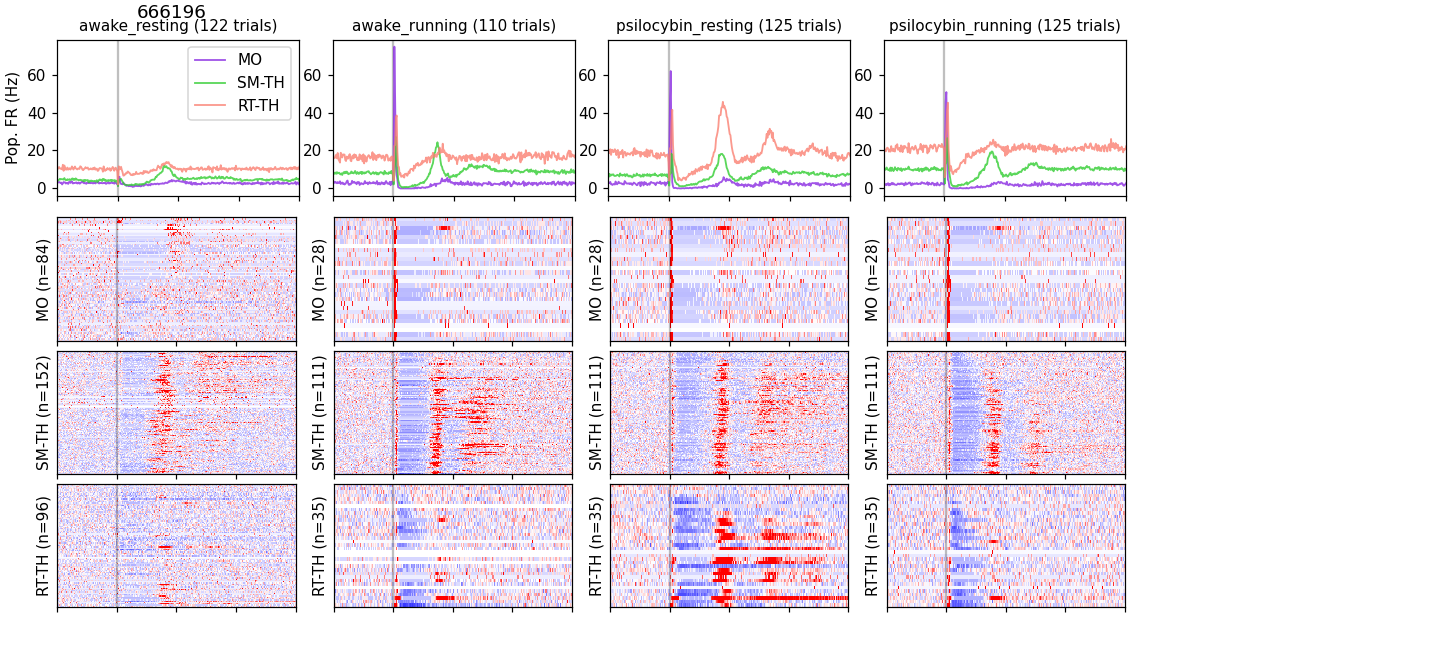

<IPython.core.display.Javascript object>


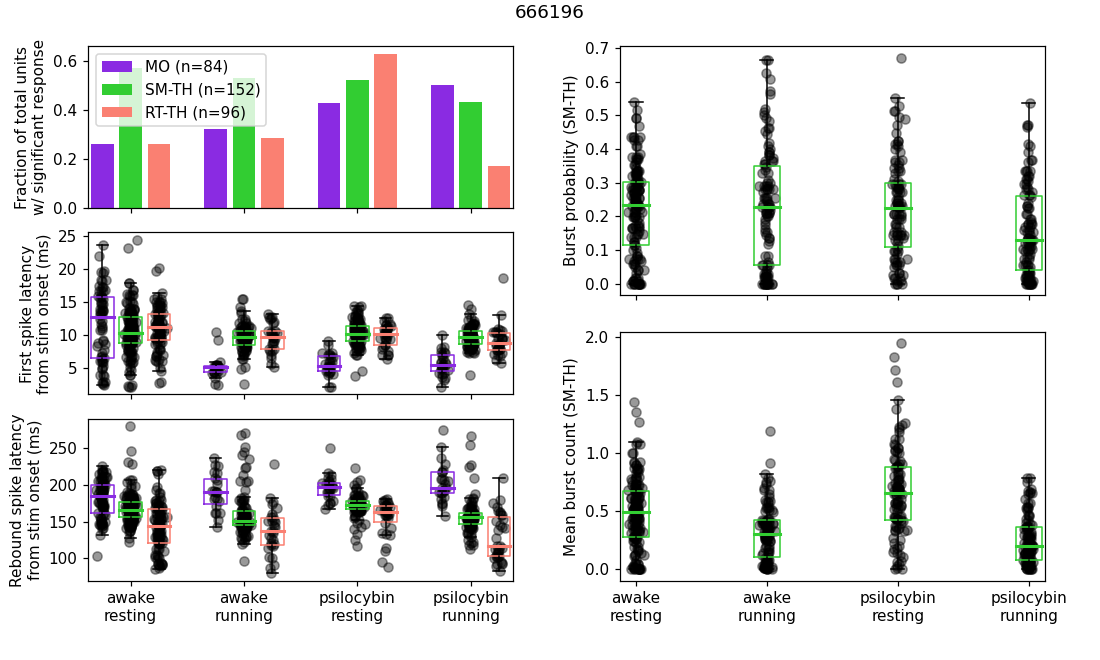

In [40]:
Zlim = 5
plwin = [-0.2, 0.6]
burst_region = 'SM-TH'

num_states = len(subject_dict['unit_zscores'])
state_reg_counts = []
for statei, regdict in subject_dict['unit_zscores'].items():
    state_reg_counts.append(np.sum([1 for x in areacolors.keys() if x in subject_dict['unit_zscores']['awake_running'].keys()]))
num_regions = np.max(state_reg_counts)
if (num_states == 1) & (num_regions == 1):
    print('Not making figures for {}.'.format(subi))
pop_firing_rates = subject_dict['pop_fr']

### Unit z-scores figure ###
fig = plt.figure(figsize=(13, 6))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 2.5], left=0.04, right=0.98, top=0.94, bottom=0.08, hspace=0.08)
popgs = gs[0].subgridspec(ncols=5, nrows=1, wspace=0.14)
Zgs = gs[1].subgridspec(ncols=5, nrows=3, hspace=0.08, wspace=0.16)

jj = 0
for statei in all_states.keys():
    if statei not in subject_dict['unit_zscores'].keys():
        continue
    if jj == 0:
        popax = fig.add_subplot(popgs[jj])
    else:
        popax = fig.add_subplot(popgs[jj], sharey=popax)
    popax.axvline(0, color='k', alpha=0.25)
    
    ii = 0
    for regi, rcolor in areacolors.items():
        if regi not in subject_dict['unit_zscores'][statei].keys():
            continue
        popax.plot(
            pop_firing_rates[statei][regi][0], pop_firing_rates[statei][regi][1],
            color=rcolor, linewidth=1.2, alpha=0.8, label=regi
        )
        datai = subject_dict['unit_zscores'][statei][regi]
        Zax = fig.add_subplot(Zgs[ii,jj])
        Zax.imshow(
            datai[1].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
            extent=[datai[0][0], datai[0][-1], 0, datai[1].shape[0]],
        )
        Zax.axvline(0, color='k', alpha=0.25)
        Zax.set_ylabel('{} (n={:d})'.format(regi, datai[1].shape[1]))
        Zax.set_yticks([])
        Zax.set_xlim(plwin)
        if ii != subject_dict['region_counts'][statei]-1:
            Zax.set_xticklabels([])
        else:
            Zax.set_xlabel('Time from stim onset (s)')
        ii += 1
    if jj == 0:
        popax.set_ylabel('Pop. FR (Hz)')
        popax.legend()
    popax.set_xlim(plwin)
    popax.set_xticklabels([])
    popax.set_title('{} ({:d} trials)'.format(statei, subject_dict['trial_counts'][statei]))
    jj += 1
        
## Title ##
fig.text(0.12, 0.98, subi, rotation='horizontal', va='center', ha='center', fontsize=12)
## Save ##
figname = '{}_evoked_unit_zscores_allstates.png'.format(subi)
fig.savefig(os.path.join(plotsdir, 'ind_sub_evoked_units', figname), transparent=False, dpi=300)



### Metrics figure ###
locs = np.arange((num_regions + 1) * num_states).reshape((num_states, (num_regions + 1)))
metfig = plt.figure(figsize=(10, 6))
gs = metfig.add_gridspec(ncols=2, nrows=1, left=0.08, right=0.95, top=0.93, bottom=0.12, wspace=0.25)
axs = gs[0].subgridspec(ncols=1, nrows=3, hspace=0.15).subplots(sharex=True)
bxs = gs[1].subgridspec(ncols=1, nrows=2, hspace=0.15).subplots(sharex=True)

ii = 0
stlabels2 = []
for statei in all_states.keys():
    if statei not in subject_dict['unit_metrics'].keys():
        continue
    jj = 0
    for regi, rcolor in areacolors.items():
        if regi not in subject_dict['unit_metrics'][statei].keys():
            continue
        reg_metrics = subject_dict['unit_metrics'][statei][regi]
        total_units = len(reg_metrics)
        xs = np.random.normal(locs[ii,jj], 0.08, total_units)
        ## Fraction of total units that are significantly activated (excited+inhibited) ##
        sig_units = np.sum(reg_metrics['p_value'].values < sigalpha)
        axs[0].bar(locs[ii,jj], sig_units/total_units, color=rcolor)

        ## Early spike latency ##
        early_lats = reg_metrics['early_latency'].values * 1E3
        axs[1].scatter(xs, early_lats, color='k', marker='o', alpha=0.4)
        axs[1].boxplot(
            early_lats[~np.isnan(early_lats)], positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
            medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
        )

        ## Late spike latency ##
        late_lats = reg_metrics['late_latency'].values * 1E3
        axs[2].scatter(xs, late_lats, color='k', marker='o', alpha=0.4)
        axs[2].boxplot(
            late_lats[~np.isnan(late_lats)], positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
            medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
        )

        if regi == burst_region:
            ## Burst probability ##
            bxs[0].scatter(xs, reg_metrics['burst_prob'].values, color='k', marker='o', alpha=0.4)
            bxs[0].boxplot(
                reg_metrics['burst_prob'].values, positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
                medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
            )

            ## Burst count ##
            bxs[1].scatter(xs, reg_metrics['burst_count'].values, color='k', marker='o', alpha=0.4)
            bxs[1].boxplot(
                reg_metrics['burst_count'].values, positions=[locs[ii,jj]], widths=[0.8], showfliers=False, 
                medianprops={'color': rcolor, 'linewidth': 2}, boxprops={'color': rcolor},
            )
        jj += 1
    if ii == 0:
        regleg = []
        for regi, rcolor in areacolors.items():
            reg_metrics = subject_dict['unit_metrics'][statei][regi]
            regleg.append(Patch(facecolor=rcolor, label='{} (n={:d})'.format(regi, len(reg_metrics))))
        axs[0].legend(handles=regleg)
    templabel = statei.split('_')
    if len(templabel) > 1:
        stlabels2.append(templabel[0] + '\n' + templabel[1])
    else:
        stlabels2.append(templabel[0])
    ii += 1

axs[0].set_ylabel('Fraction of total units\nw/ significant response')
axs[1].set_ylabel('First spike latency\nfrom stim onset (ms)')
axs[2].set_ylabel('Rebound spike latency\nfrom stim onset (ms)')
axs[2].set_xticks(np.mean(locs[:,:-1], axis=1))
axs[2].set_xticklabels(stlabels2)

bxs[0].set_ylabel('Burst probability ({})'.format(burst_region))
bxs[1].set_ylabel('Mean burst count ({})'.format(burst_region))
bxs[1].set_xticks(locs[:,1])
bxs[1].set_xticklabels(stlabels2)

## Title ##
metfig.text(0.5, 0.98, subi, rotation='horizontal', va='center', ha='center', fontsize=12)
## Save ##
mfigname = '{}_unit_metrics_allstates.png'.format(subi)
metfig.savefig(os.path.join(plotsdir, 'ind_sub_evoked_units', mfigname), transparent=False, dpi=300)

### Make single subject example plots

This may not work correctly due to some subjects having duplicate states across recordings, see above for solution.